<a href="https://colab.research.google.com/github/sakshilade/DEEPLEARNING/blob/main/ExplainableAIActivty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bca72c8784d6f3effd88e5e3a3f38bdb69bb6d42baaa30c2a1cd5298ee43002d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


📊 Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



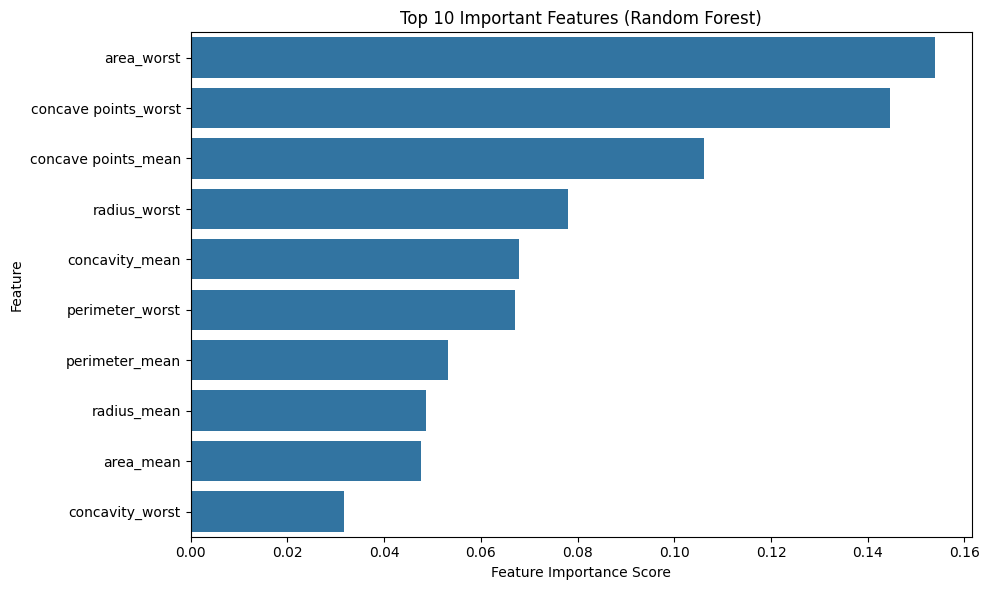

<Figure size 640x480 with 0 Axes>

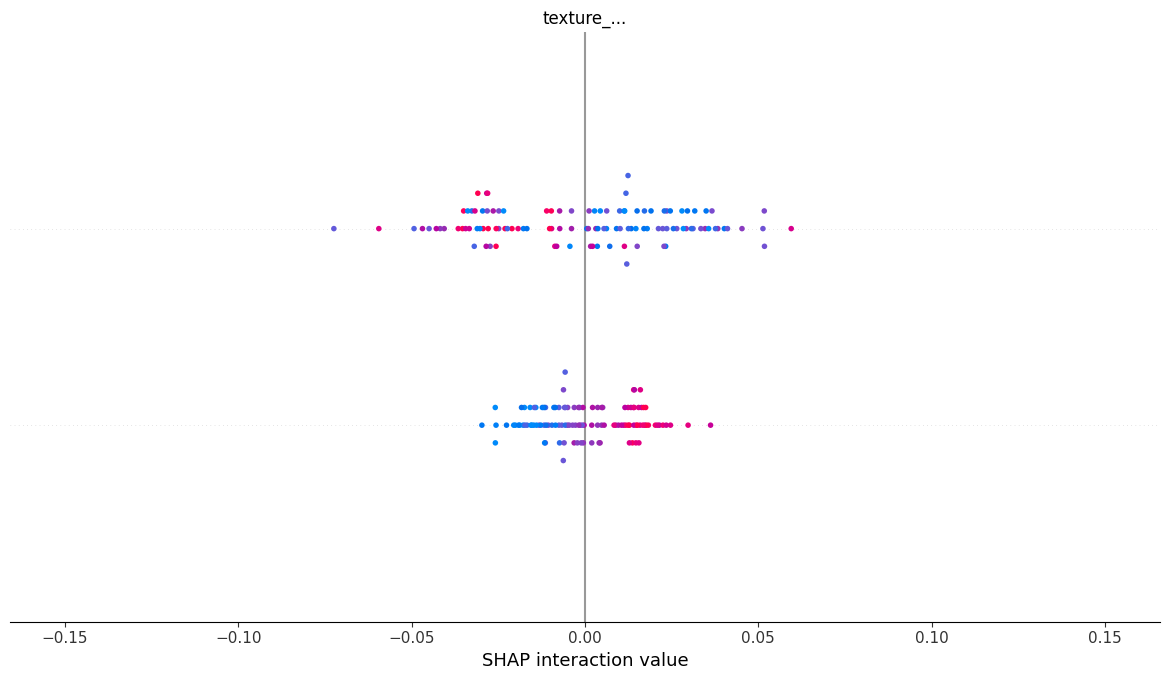

🔍 SHAP Local Explanation for Sample 5 (Class 1 - Malignant):


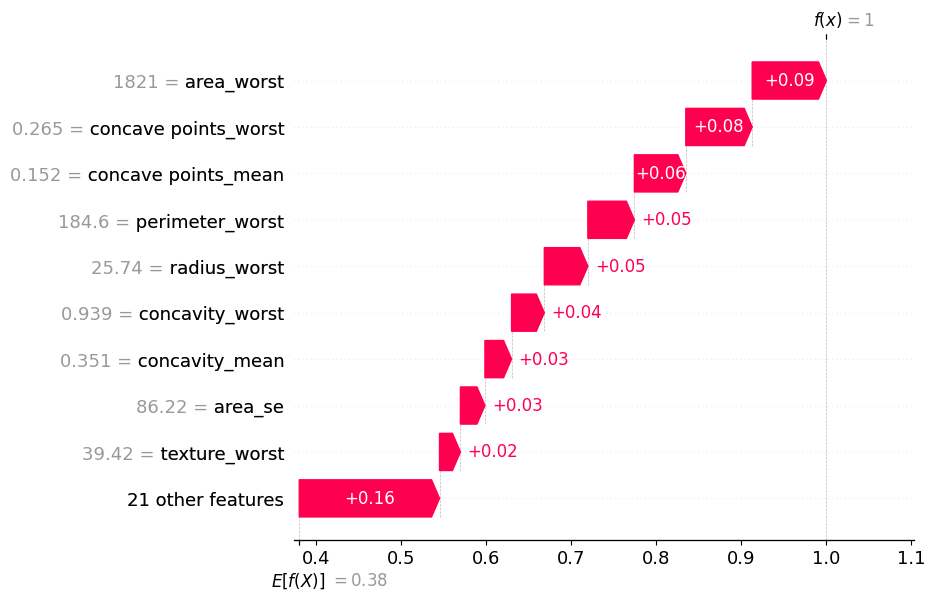

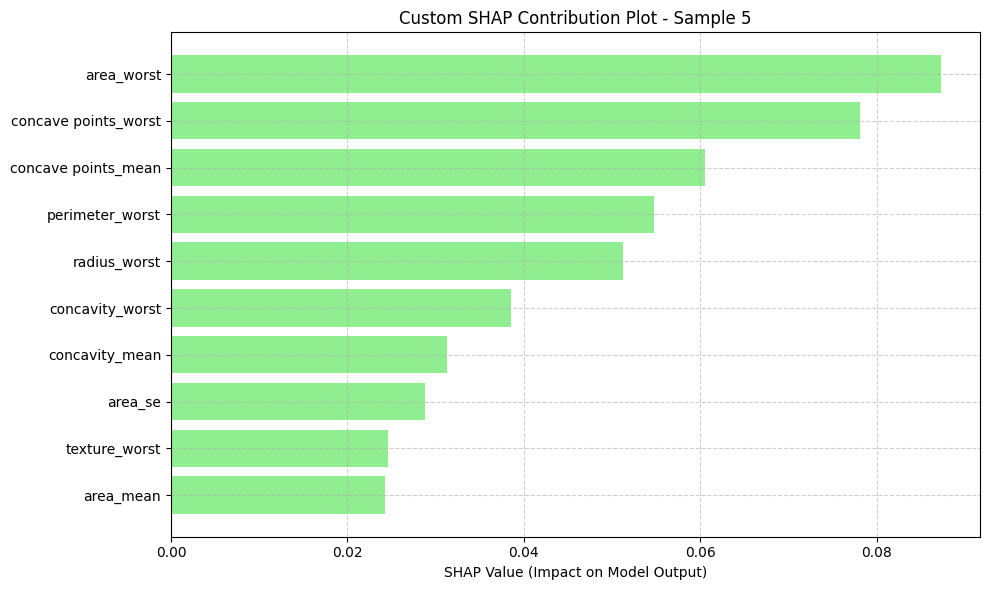

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

#  Load and Prepare Dataset

df = pd.read_csv("data.csv")

df.drop(columns=['id', 'Unnamed: 32'], inplace=True, errors='ignore')

label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])  # M=1, B=0

X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Feature Importance (Global - RF)

feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.head(10), y=feature_imp.head(10).index)
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#  SHAP Explanation

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

#  Global Interpretation
shap.summary_plot(shap_values, X_test, plot_type='bar')


# Local Explanation for a Sample

sample = 5
print(f"🔍 SHAP Local Explanation for Sample {sample} (Class 1 - Malignant):")

# Waterfall plot for local explanation
shap.plots.waterfall(shap_values[sample, :, 1])


#  Custom Cumulative Contribution Plot

contribs = shap_values[sample, :, 1].values
feature_names = X_test.columns
sorted_idx = np.argsort(np.abs(contribs))[::-1][:10]  # Top 10 influential features

plt.figure(figsize=(10, 6))
bars = plt.barh(
    np.array(feature_names)[sorted_idx],
    contribs[sorted_idx],
    color=["salmon" if val < 0 else "lightgreen" for val in contribs[sorted_idx]]
)
plt.xlabel("SHAP Value (Impact on Model Output)")
plt.title(f"Custom SHAP Contribution Plot - Sample {sample}")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [47]:
import lime
import lime.lime_tabular

# Create LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Benign', 'Malignant'],
    mode='classification'
)

# Explain instance
exp = lime_explainer.explain_instance(X_test.values[sample], model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
